# Autoencoders

In this notebook, I borrow heavily from [the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html). So rather than sprinkling references to the Keras blog throughout the notebook, just assume I stole it from [Francois Chollet](https://twitter.com/fchollet). Because open source or something.

![stole from Keras blog](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

So, autoencoders. They're legit. They do perform data compression but not in the JPEG or MPEG way -- these fellas make some broad assumptions about images, sound, and video and apply compression based on the assumptions.

Autoencoders **learn** (automatically) a lossy compression based on the data examples fed in. So the compression is specific to those examples.

## What's Required

Autoencoders require 3 things:

1. Encoding function
2. Decoding function
3. Loss function describing the amount of information loss between the compressed and decompressed representations of the data examples and the decompressed representation (i.e. a "loss" function).

The encoding/decoding functions are typically (parametric) neural nets and are differentiable with respect to the distance function. The differentiable part enables optimizing the parameters of the encoding/decoding functions to minimize the reconstruction loss.

## What Are They Good For

1. Data Denoising
2. Dimension Reduction
3. Data Visualization (basically the same as 2, but plots)

For data denoising, think PCA, but nonlinear. In fact, if the encoder/decoder functions are linear, the result spans the space of the PCA solution. The nonlinear part is useful because they can capture, for example, multimodality in the feature space, which PCA can't.

Dimension reduction is a direct result of the lossy compression of the algorithm. It can help with denoising and **pre-training** before building another ML algorithm. But is the compression good enough to replace JPEG or MPEG? Nope. And probably not anytime soon. But maybe one day.

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential  # TODO: Rm Sequential?
from keras.layers import Input, Dense

Using TensorFlow backend.


# Data Loading and Preprocessing

In [2]:
# Loads the training and test data sets (ignoring class labels)
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
# Scales the training and test data to range between 0 and 1.
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

In [4]:
# 60K training 28 x 28 (pixel) images
x_train.shape

(60000, 28, 28)

In [5]:
# 10K test 28 x 28 (pixel) images
x_test.shape

(10000, 28, 28)

In [6]:
# Reshapes 28 x 28 images into vectors of length 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

(x_train.shape, x_test.shape)

((60000, 784), (10000, 784))

In [7]:
input_dim = x_train.shape[1]

# Simple Autoencoder

A single fully-connected neural layer as an encoder function and an decoder function.

In [8]:
# Size of our encoded representations
encoding_dim = 32

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

# Input placeholder
input_img = Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Compression factor: 24.5


## Encoder Model

In [9]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## Decoder Model

In [10]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [11]:
# Trains the model, iterating on the training data in batches of 256 in 50 epochs.
# Using the Adadelta optimizer and per-pixel binary crossentropy loss.
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s - loss: 0.3755 - val_loss: 0.2721
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 0.2647 - val_loss: 0.2540
Epoch 3/50
60000/60000 [==============================] - 6s - loss: 0.2440 - val_loss: 0.2319
Epoch 4/50
60000/60000 [==============================] - 6s - loss: 0.2239 - val_loss: 0.2139
Epoch 5/50
60000/60000 [==============================] - 7s - loss: 0.2088 - val_loss: 0.2013
Epoch 6/50
60000/60000 [==============================] - 6s - loss: 0.1979 - val_loss: 0.1918
Epoch 7/50
60000/60000 [==============================] - 6s - loss: 0.1895 - val_loss: 0.1843
Epoch 8/50
60000/60000 [==============================] - 6s - loss: 0.1826 - val_loss: 0.1782
Epoch 9/50
60000/60000 [==============================] - 7s - loss: 0.1769 - val_loss: 0.1729
Epoch 10/50
60000/60000 [==============================] - 6s - loss: 0.1719 - val_loss: 0.1682

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

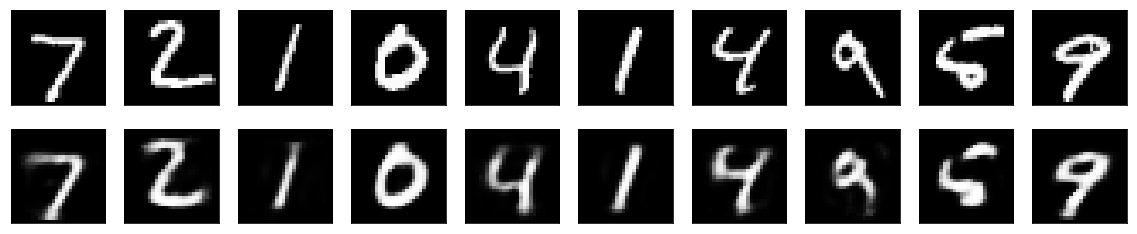

In [13]:
# Number of digits to display
n = 10  
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()